# Assignment 2 (William Cromar)

Complete dataset (data.csv) includes residential, single family homes in Orange County FL, from the past three years (as of March 15, 2017). Sales less than $100 dollars have been excluded from the dataset.

Data was queried from the Orange County Property Appraiser's website, using the Sales Search utility. (Link: http://www.ocpafl.org/searches/ParcelSearch.aspx)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data

notes about data

In [2]:
# Read in the data from the CSV
data_raw = pd.read_csv("data.csv")

# Only include sales of type "SALE QUALIFIED AS RESULT OF DEED EXAMINATION" (code 1)
data_raw = data_raw[data_raw["SaleDescriptionCode"] == 1]

# Pull the year out of each year's time stamp
# Time stamps follow the form MM/DD/YYYY HH:MM:SS
data_raw["Year Sold"] = data_raw["Date of Sale"].map(lambda timestamp: int(timestamp.split(" ")[0].split("/")[2]))

# I'm also going to drop datapoints that have an average year built after they were sold
# ie building plans that were sold
data_raw = data_raw[data_raw["Average Year Built"] <= data_raw["Year Sold"]]

# Determine the house's age at the time of sale
data_raw["Age at Sale"] = data_raw["Year Sold"] - data_raw["Average Year Built"]

print data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6197 entries, 0 to 9999
Data columns (total 33 columns):
Parcel ID                  6197 non-null object
Property Address           6197 non-null object
Street Number              6197 non-null int64
Street Direction           6197 non-null object
Street Name                6197 non-null object
Street Type                6197 non-null object
Unit Number                6197 non-null object
Heated Area                6197 non-null int64
Bedrooms                   6197 non-null int64
Bathrooms                  6197 non-null float64
Book                       6197 non-null object
Page                       6197 non-null object
Instrument Number          6197 non-null int64
PID                        6197 non-null int64
Link                       6197 non-null object
Mailing Address 1          6197 non-null object
Mailing Address 2          6197 non-null object
Mailing Address City       6197 non-null object
Mailing Address State      6197 n

In [3]:
# Extract useful data from data_raw
data = pd.DataFrame()
data["VALUE"] = data_raw["Sale Amount"]
data["BED"] = data_raw["Bedrooms"]
data["BATH"] = data_raw["Bathrooms"]
data["AREA"] = data_raw["Heated Area"]
data["AGE"] = data_raw["Age at Sale"]
data["TYPE"] = data_raw["Property Use Type"]

print data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6197 entries, 0 to 9999
Data columns (total 6 columns):
VALUE    6197 non-null int64
BED      6197 non-null int64
BATH     6197 non-null float64
AREA     6197 non-null int64
AGE      6197 non-null int64
TYPE     6197 non-null object
dtypes: float64(1), int64(4), object(1)
memory usage: 338.9+ KB
None


## Visualizations

Let's try to visualize the interactions between variables.

### Distribution of home values

First off, what does the distribution of sale prices look like?

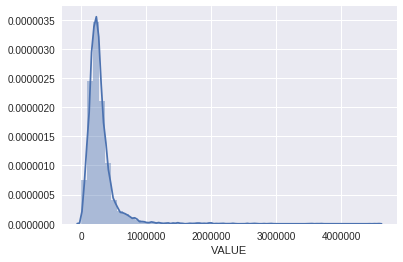

In [4]:
# What does the distribution of sale prices look like?
sns.distplot(data["VALUE"])

The data appears quite skewed to the right. Perhaps I can improve the quality of my model if I transform the data to be more normal.

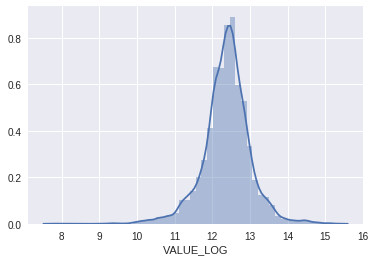

In [5]:
data["VALUE_LOG"] = np.log(data["VALUE"])
sns.distplot(data["VALUE_LOG"])

This looks significantly more normally distrbuted than the un-logged version. I could attempt to use it as the predicted variable in my model later on, but the trade off would be model interpretability.

### Relations between numerical variables

Next up, let's visualize the relationships between the numerical variables in the dataset.

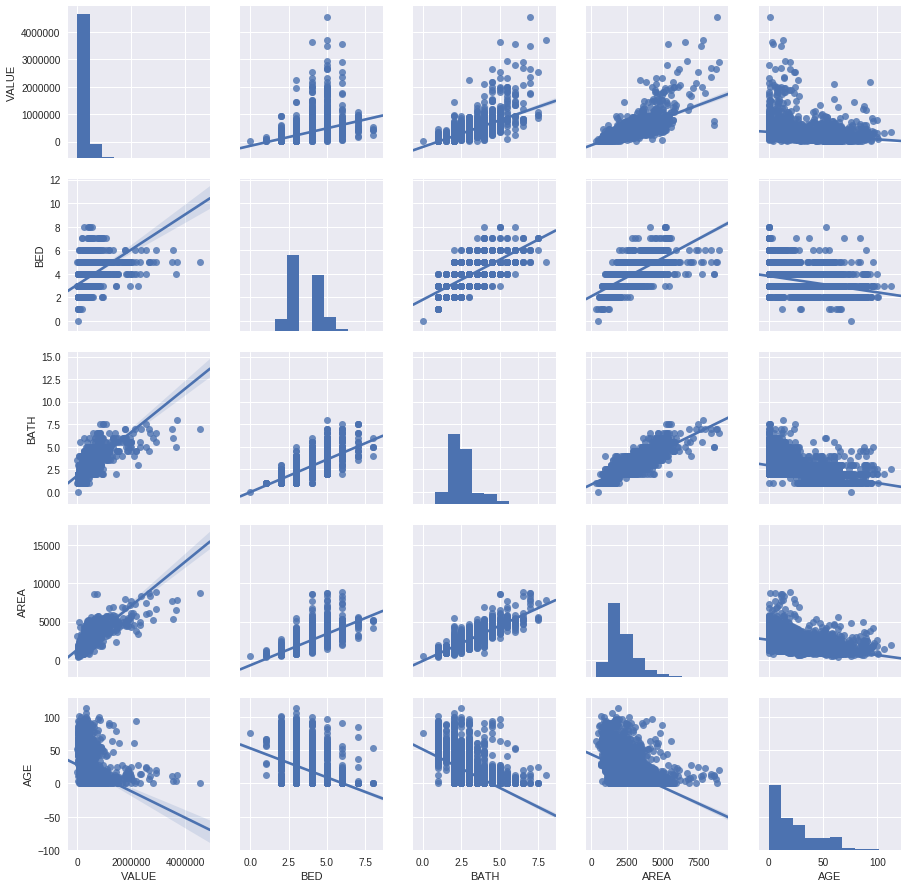

In [6]:
sns.pairplot(data=data.drop(["TYPE", "VALUE_LOG"], axis=1), kind="reg")

Here are some quick observations:
1. Looking at the top row, value seems to most strongly correlated with heated area, but also seems to be somewhat correlated with the number of bedrooms and bathrooms, respectively. Value seems to be mostly uncorrelated with the age of the house at the time of its sale.
2. There are strong co-linearities between independent variables. Particularly, the number of bedrooms and bathrooms seems to be quite co-linear with the heated area of the house. This makes sense: adding a room to house will add to its interior area.

### Nominal Variable: Type

Next, let's see if the nominal variable (home type) has any significant impact on the value of that home.

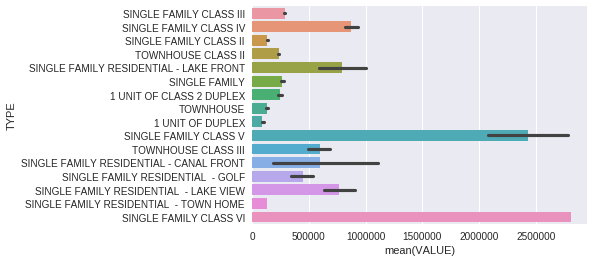

In [11]:
sns.barplot(x="VALUE", y="TYPE", data=data)